In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/BONECANCERSEGMENTATION.v1i.clip.zip -d /content/

Archive:  /content/drive/MyDrive/BONECANCERSEGMENTATION.v1i.clip.zip
replace /content/README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**model**

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import shutil
import glob

In [6]:
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAvgPool2D
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras

In [7]:
#model building
model =Sequential()
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(224,224,3)))

model.add(Conv2D(36,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(rate=0.25))

model.add(Dense(1,activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 36)        │           5,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 36)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 64)        │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,176,165 (42.63 MB)

 Trainable params: 11,176,165 (42.63 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [9]:
#train
def preprocessingimages(path):

  image_data=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

In [10]:
train_data=preprocessingimages('/content/train')

Found 1789 images belonging to 2 classes.


In [11]:
#test
def preprocessingimages2(path):

  image_data=ImageDataGenerator(rescale=1./255)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=32,class_mode='binary')
  return image

In [12]:
test_data=preprocessingimages2('/content/test')

Found 70 images belonging to 2 classes.


In [13]:
vali_data=preprocessingimages2('/content/valid')


Found 72 images belonging to 3 classes.


In [14]:
#early stopping and model check point

from keras.callbacks import ModelCheckpoint,EarlyStopping

#early stopping
es=EarlyStopping(monitor="val_accuracy",min_delta=0.01,patience=6,verbose=1,mode='auto')

#model check point
mc=ModelCheckpoint(filepath="best_model.keras",monitor="val_accuracy",verbose=1,save_best_only=True,mode='auto')

#put call back in a list
cb=[es,mc]

In [15]:
hs=model.fit(train_data,
             steps_per_epoch=16,
             epochs=50,
             verbose=1,
             callbacks=cb,
             validation_data=vali_data,
             validation_steps=16)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.7633 - loss: 0.3955

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_accuracy improved from -inf to 0.93056, saving model to best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 793ms/step - accuracy: 0.7701 - loss: 0.3923 - val_accuracy: 0.9306 - val_loss: 0.2880
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.9450 - loss: 0.2430
Epoch 2: val_accuracy did not improve from 0.93056
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 350ms/step - accuracy: 0.9448 - loss: 0.2430 - val_accuracy: 0.9306 - val_loss: 0.2484
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9399 - loss: 0.2033
Epoch 3: val_accuracy did not improve from 0.93056
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 278ms/step - accuracy: 0.9400 - loss: 0.2022 - val_accuracy: 0.9306 - val_loss: 0.2343
Epoch 4/50
 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9516 - loss: 0.1873
Epoch 4: val_accuracy did not improve from 0.93056
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9445 - loss: 0.2032 - val_accuracy: 0.9306 - val_loss: 0.2198
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━

In [16]:
#model graphical interpretation

h= hs.history
print(h.keys()) # Print the keys directly

# Or convert to a list and print:
keys_list = list(h.keys())
print(keys_list)

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
['accuracy', 'loss', 'val_accuracy', 'val_loss']


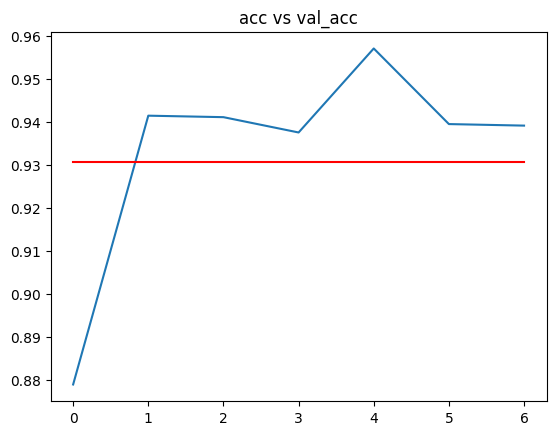

In [17]:
import matplotlib.pyplot as plt
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'],c='red')
plt.title('acc vs val_acc')
plt.show()

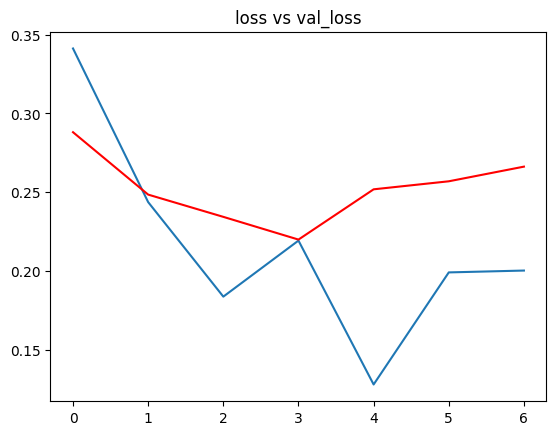

In [18]:
import matplotlib.pyplot as plt
plt.plot(h['loss'])
plt.plot(h['val_loss'],c='red')
plt.title('loss vs val_loss')
plt.show()

In [19]:
from keras.models import load_model
model=load_model('/content/best_model.keras')

In [20]:
#model accuracy

acc=model.evaluate(test_data)[1]
print(f"the accuracy of model is {acc*100}%")


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 594ms/step - accuracy: 0.9291 - loss: 0.2499
the accuracy of model is 92.85714030265808%


In [21]:
from keras.preprocessing.image import load_img,img_to_array

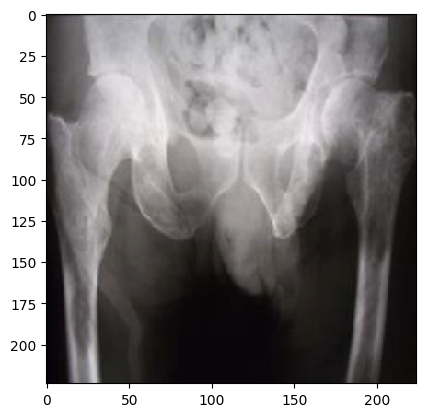

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
0.11146545
cancer


In [22]:
path="/content/valid/cancer_multiple/pelvis_metastasis_16_png.rf.c293ccf1845bc9f3f8f3355fc71d0fab.jpg"
img=load_img(path,target_size=(224,224))
input_arr=img_to_array(img)/225
input_arr.shape

plt.imshow(input_arr)
plt.show()

input_arr=np.expand_dims(input_arr,axis=0)

pred_prob=model.predict(input_arr)[0][0]
print(pred_prob)
if pred_prob<0.2:
  print("cancer")
else:
  print("normal")

In [23]:
train_data.class_indices

{'cancer': 0, 'cancer_multiple': 1}

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Precision (Selectivity)
pred = (pred_prob >= 0.5).astype(int)
true_val=1
precision = precision_score([true_val],[pred])

# Recall (Sensitivity)
recall = recall_score([true_val],[pred])

# F1 Score
f1 = f1_score([true_val],[pred])

# ROC-AUC
#roc_auc = roc_auc_score([true_val],[pred])  # Use probability scores for ROC-AUC

# Specificity
#tn, fp, fn, tp = confusion_matrix([train_data],[test_data])

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
#print("ROC-AUC:", roc_auc)
#print("Specificity:", specificity)


Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
